In [53]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

import seaborn as sns
import matplotlib.pyplot as plt

# Import des données

In [2]:
train_data = pd.read_csv('train_set.csv', index_col='id')
test_data = pd.read_csv('validation_set.csv', index_col='id')
labels = train_data.columns[1:]

In [3]:
display(test_data.head())

,cleaned_plots,Drama,Comedy,Romance Film,Thriller,Action,World cinema,Crime Fiction,Horror,Black-and-white,...,Coming of age,Martial Arts Film,Cult,Sports,Television movie,Slasher,Suspense,Biographical film,Biography,Supernatural
id,,,,,,,,,,,,,,,,,,,,,
4343361,alex kovac playing poker new york city drops g...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4730,gotham city batman stops hostage situation ban...,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
32037191,small town guy tries decide staying current gi...,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27376549,montreal west high school student leon bronste...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18586060,ice people brings anne aghion crew antarctica ...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Représentation des données

Représentation Tf-Idf des données, conservant uniquement les termes présents dans plus de 10 textes et au maximum dans 20% des documents.

In [123]:
tf_idf_vectorizer = TfidfVectorizer(max_df=0.20 ,min_df=10, token_pattern='\S+')
X = tf_idf_vectorizer.fit_transform(train_data['cleaned_plots'])

In [124]:
print(len(tf_idf_vectorizer.get_feature_names()))

23638


In [125]:
y = train_data.iloc[:,1:]
print(y.shape)

(29806, 50)


In [126]:
display(X)

<29806x23638 sparse matrix of type '<class 'numpy.float64'>'
	with 3249138 stored elements in Compressed Sparse Row format>

Séparation en train / validation set

In [127]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Dummy classifier

Création d'un classifieur naif prédisant les genres selon la distribuion du set d'entrainement

In [128]:
def get_score(ground_truth, predictions):
    global_score = precision_recall_fscore_support(ground_truth, predictions, average='macro')
    score = pd.DataFrame(precision_recall_fscore_support(ground_truth, predictions, average=None)).T
    score.columns = ['precision', 'recall', 'F1_score', 'count']
    score.index = labels
    return global_score, score

In [129]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [130]:
d_global_train_score, d_train_score = get_score(y_train, dummy_clf.predict(X_train))
d_global_val_score, d_val_score = get_score(y_val, dummy_clf.predict(X_val))

Performances (précision, rappel, F1 score) :

In [131]:
display(d_global_train_score)
display(d_global_val_score)

(0.060767975322731906, 0.060582201503300626, 0.060668423132187954, None)

(0.0623673365917411, 0.06258710036072188, 0.062359325546468475, None)

# SVM

Modélisation avec un classifieur SVM et recherche du paramètre de régularisation :

In [132]:
parameters = (0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005)

In [162]:
precision_results = pd.DataFrame(columns=['alpha', 'train', 'val'])
recall_results = pd.DataFrame(columns=['alpha', 'train', 'val'])
F1_results = pd.DataFrame(columns=['alpha', 'train', 'val'])

for alpha in parameters:

    SVM_model = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', alpha=alpha))
    SVM_model.fit(X_train, y_train)
    
    train_score = precision_recall_fscore_support(y_train, SVM_model.predict(X_train), average='macro')
    val_score = precision_recall_fscore_support(y_val, SVM_model.predict(X_val), average='macro')

    precision_results = precision_results.append({'alpha': alpha, 'train': train_score[0], 'val':val_score[0]},ignore_index=True)
    recall_results = recall_results.append({'alpha': alpha, 'train': train_score[1], 'val':val_score[1]},ignore_index=True)
    F1_results = F1_results.append({'alpha': alpha, 'train': train_score[2], 'val':val_score[2]}, ignore_index=True)

precision_results.set_index('alpha', drop=True, inplace=True)
recall_results.set_index('alpha', drop=True, inplace=True)
F1_results.set_index('alpha', drop=True, inplace=True)

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/

Visualisation des résultats d'entrainement :

Text(0.5, 1.0, 'F1_score')

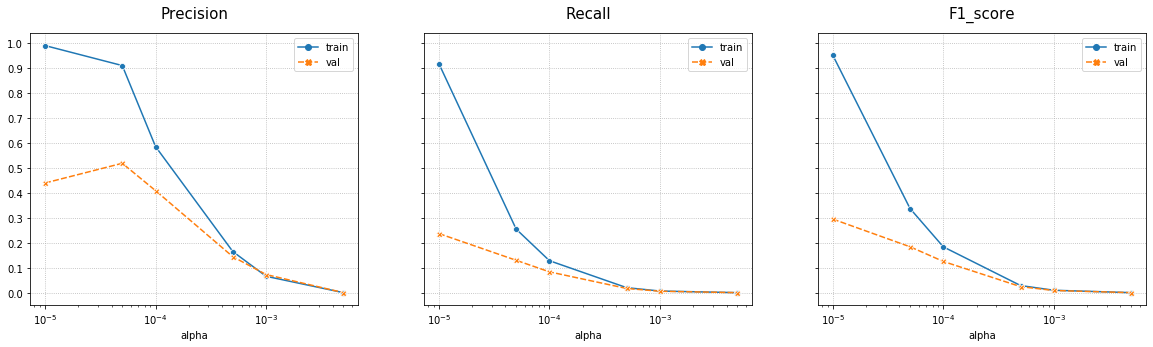

In [181]:
fig, (ax0, ax1, ax2) = plt.subplots(1,3, sharey=True, figsize=(20,5))
sns.lineplot(data=precision_results, markers=True, ax=ax0)
ax0.set_xscale('log')
ax0.grid(True, linestyle=':')
ax0.set_title('Precision', fontsize=15, pad=15)
plt.yticks(np.arange(0,1.1,0.1))

sns.lineplot(data=recall_results, markers=True, ax=ax1)
ax1.set_xscale('log')
ax1.grid(True, linestyle=':')
ax1.set_title('Recall', fontsize=15, pad=15)

sns.lineplot(data=F1_results, markers=True, ax=ax2)
ax2.set_xscale('log')
ax2.grid(True, linestyle=':')
ax2.set_title('F1_score', fontsize=15, pad=15)

On etient comme paramètre de régularisation alpha = 0.0001

# Analyse des résultats test set

In [183]:
def score_vis(score):
    precision = score['precision'].sort_index()
    recall = score['recall'].sort_index()
    nb = score['count'].sort_index()
    
    fig, (ax0, ax1, ax2) = plt.subplots(3,1, sharex=True, figsize=(20,12))
    
    sns.barplot(x=precision.index, y=precision.values, ax=ax0)
    ax0.set_title('Precision', pad=15, fontsize=20)
    ax0.set_ylabel('Precision', fontsize=15, labelpad=15)
    
    sns.barplot(x=recall.index, y=recall.values, ax=ax1)
    ax1.set_title('Recall', pad=15, fontsize=20)
    ax1.set_ylabel('Recall', fontsize=15, labelpad=15)
    
    sns.barplot(x=nb.index, y=nb.values, ax=ax2)
    ax2.set_title('Count', pad=15, fontsize=20)
    ax2.set_ylabel('Count', fontsize=15, labelpad=15) 
    
    plt.xticks(rotation='vertical')

In [182]:
final_SVM_model = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', alpha=0.0001))
final_SVM_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [184]:
X_test = tf_idf_vectorizer.transform(test_data['cleaned_plots'])

In [186]:
global_test_score, test_score = get_score(test_data.iloc[:,1:], final_SVM_model.predict(X_test))

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Performances (précision, rappel, F1 score) :

In [188]:
display(global_test_score)

(0.411485867081045, 0.08501330781199964, 0.1267795957369233, None)

Détails des scores par classe :

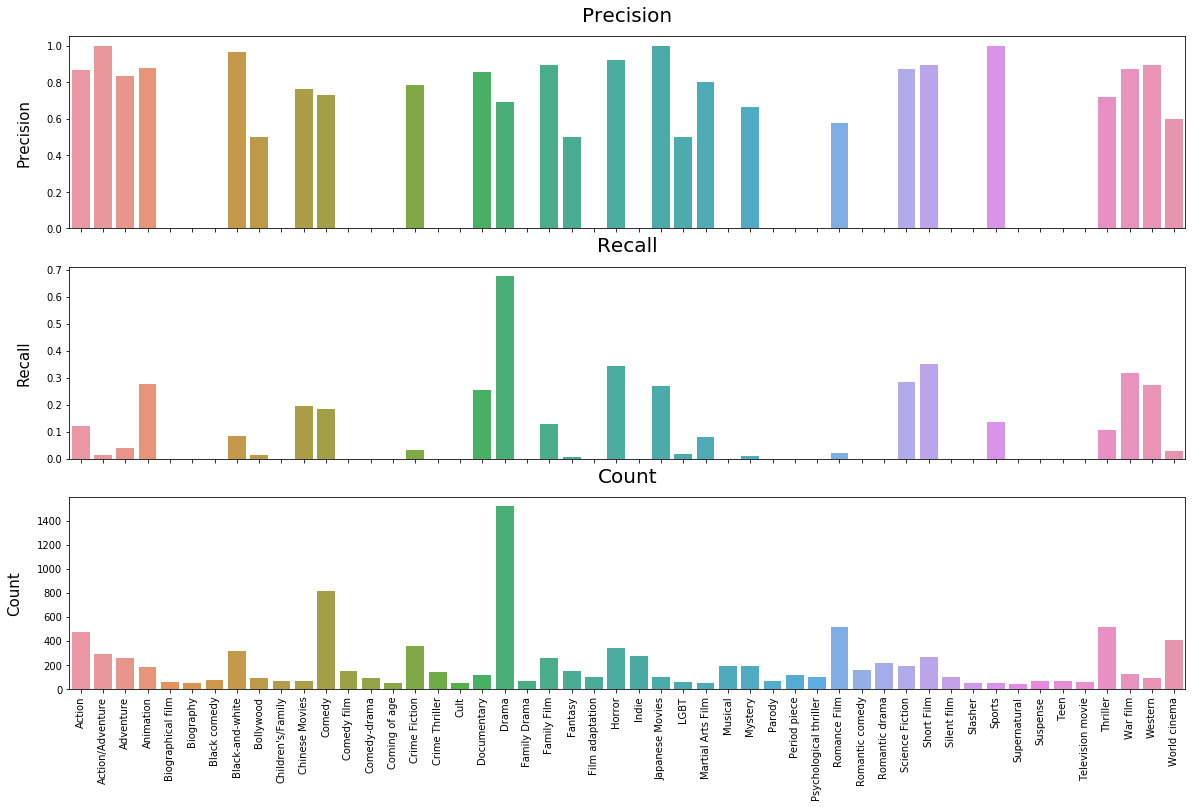

In [189]:
score_vis(test_score)